### <b>Importing needed libaries<b>

In [1]:
from ipywidgets import FloatProgress
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from copy import copy
import re
import math
import seaborn as sns

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from etl import load_files_into_df, preprocess_text, layer_normalize

### <b>Loading `distiluse-base-multilingual-cased-v1` model<b>

In [84]:
model = SentenceTransformer(os.path.join('..', 'mpnet_finetuned', '18500'))

In [61]:
# model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

In [76]:
SEED = 42
random.seed(SEED)

### <b>Load dataset<b>

In [35]:
filename = 'preprocessed_with_categories.csv'
df = pd.read_csv(
    os.path.join('..', 'data-preprocessed', filename))

### <b>Clear contents - prepare for modeling<b>

In [36]:
EXT = '.csv'
EMPTY_CONTENTS_SUFFIX = '_EMPTY_CONTENTS'

In [37]:
empty_contents_indexes = np.where(df['content'].apply(lambda x: not isinstance(x, str)))[0]
# df.iloc[empty_contents_indexes].to_csv(
#     path_or_buf=f'{os.path.split(filename)[0]}{EMPTY_CONTENTS_SUFFIX}{EXT}',
#     index=True)
df.drop(index=empty_contents_indexes, inplace=True)

In [38]:
len(df)

3472

In [39]:
sentences = list(map(preprocess_text, df['content']))

### <b>Create sentence embeddings<b>

In [85]:
sentence_embeddings = model.encode(
    # [s for s in sentences if len(s.split(' ')) > 15],
    sentences=sentences,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True)

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

### <b>Apply dimensionality reduction - UMAP<b>

In [78]:
import umap.umap_ as UMAP

In [97]:
clusterable_embeddings = UMAP.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=5,
    random_state=42,
    metric='cosine'
).fit_transform(sentence_embeddings)

In [98]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          min_samples=5,
                          metric='euclidean',                      
                          cluster_selection_method='leaf').fit(clusterable_embeddings)

In [99]:
cluster.labels_

array([-1, -1, -1, ..., -1, -1, 36], dtype=int64)

In [100]:
sh_score = silhouette_score(
    clusterable_embeddings[np.where(cluster.labels_ != -1)[0], :], 
    cluster.labels_[np.where(cluster.labels_ != -1)[0]])

In [101]:
sh_score

0.43261653

In [102]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = UMAP.UMAP(
    n_neighbors=15, 
    n_components=2, 
    min_dist=0.0, 
    metric='cosine').fit_transform(sentence_embeddings)

In [103]:
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

In [104]:
len(set(result['labels']))

43

In [105]:
result['labels'].value_counts()

labels
-1     2194
 6       84
 10      63
 5       49
 17      47
 36      46
 19      43
 30      43
 24      43
 18      42
 15      42
 29      41
 32      37
 21      34
 13      32
 23      32
 22      32
 16      32
 34      31
 9       29
 11      29
 38      29
 12      28
 8       28
 2       24
 14      23
 37      22
 3       21
 1       21
 39      21
 7       20
 25      20
 0       19
 4       19
 41      19
 35      18
 27      18
 31      17
 28      17
 40      16
 26      16
 33      16
 20      15
Name: count, dtype: int64

In [106]:
result

,x,y,labels
0,12.901758,-1.223171,-1
1,12.034373,0.267543,-1
2,10.420034,2.213882,-1
3,11.291332,1.421800,-1
4,8.755550,0.679942,41
...,...,...,...
3467,13.196152,2.295169,6
3468,12.024193,2.617435,-1
3469,12.006238,2.612008,-1
3470,8.967327,1.708582,-1


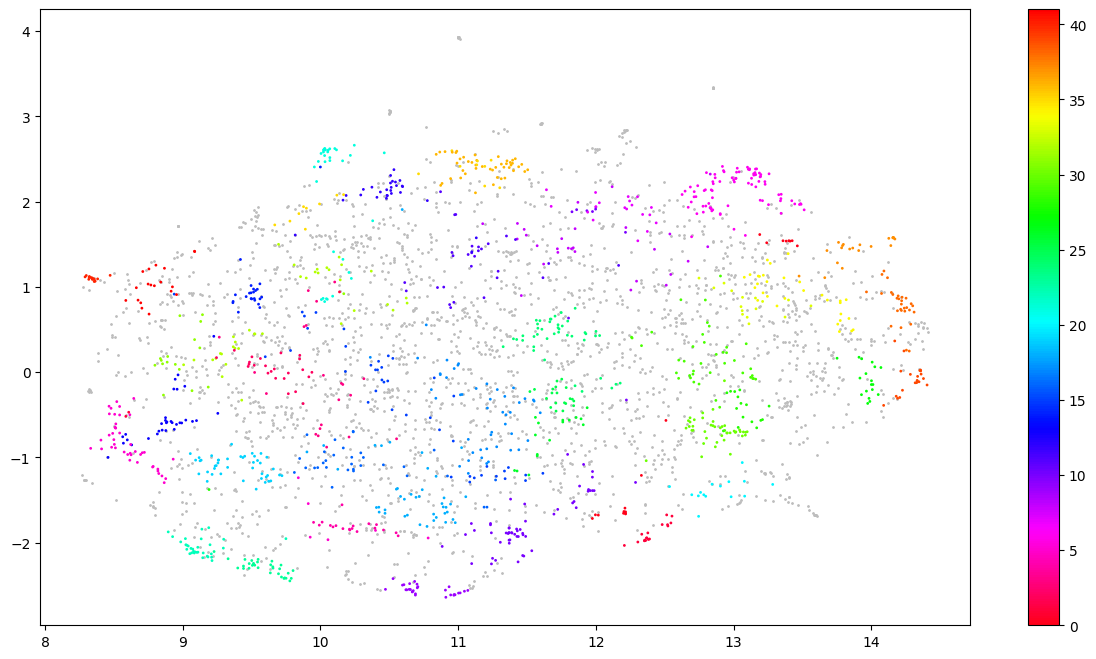

In [107]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')
plt.colorbar()
plt.show()

### <b>Normalize output

In [23]:
normalized_embeddings = np.apply_along_axis(
    layer_normalize, 
    axis=-1, 
    arr=clusterable_embeddings)

### **At first I will try with simple `K-Means clustering`**

In [85]:
wss_scores = []

for k in range(12, 18):

    kmeans = KMeans(
        n_clusters=k, 
        n_init=100, 
        random_state=SEED,
        max_iter=2000)
    
    kmeans.fit(clusterable_embeddings)    
    wss_scores.append(kmeans.inertia_)
    
    sh_score = silhouette_score(
        clusterable_embeddings, 
        kmeans.labels_)

    print(f"Silhouette score for k = {k}: {sh_score}")

Silhouette score for k = 12: 0.429904580116272
Silhouette score for k = 13: 0.4430448114871979
Silhouette score for k = 14: 0.4481312334537506
Silhouette score for k = 15: 0.4547732174396515
Silhouette score for k = 16: 0.44982075691223145
Silhouette score for k = 17: 0.45038411021232605


In [86]:
kmeans = KMeans(
    n_clusters=17, 
    n_init=100, 
    random_state=SEED,
    max_iter=4000)
    
kmeans.fit(clusterable_embeddings)

KMeans(max_iter=4000, n_clusters=17, n_init=100, random_state=42)

In [87]:
sh_score = silhouette_score(
        clusterable_embeddings, 
        kmeans.labels_)
sh_score

0.4503841

In [31]:
df['Predicted'] = result['labels'].copy()

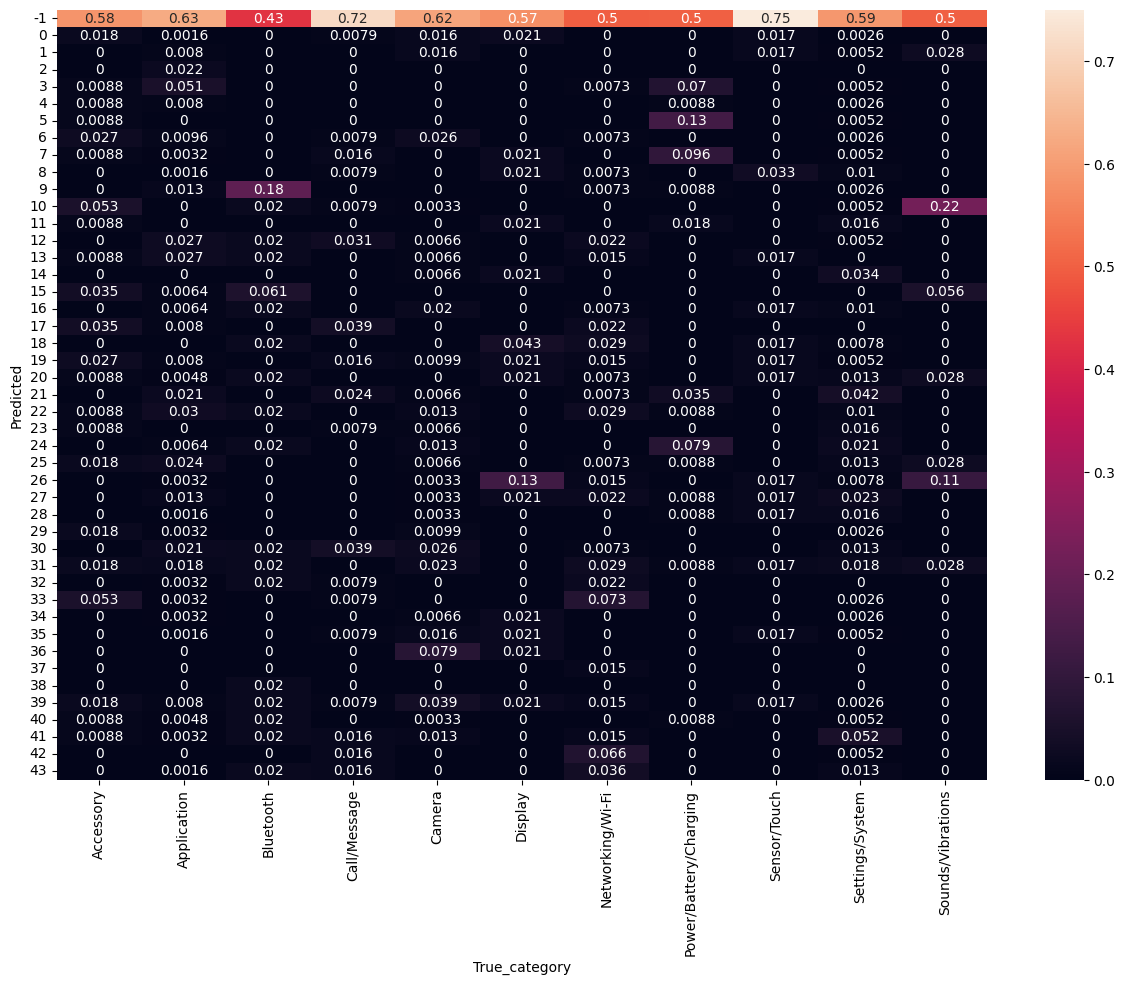

In [32]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.crosstab(
    index=df.loc[df['True_category'] != '<NO_VALUE>']['Predicted'], 
    columns=df.loc[df['True_category'] != '<NO_VALUE>']['True_category'],
    normalize='columns'), 
    annot=True,
    ax=ax)

plt.show()

In [66]:
df['Predicted'].value_counts()

Predicted
12    374
11    356
3     347
9     333
4     303
1     300
0     244
5     232
2     222
6     206
7     201
8     197
10    157
Name: count, dtype: int64

In [61]:
df.loc[df['content'].str.split().str.len() < 3]['Predicted'].value_counts()

Predicted
8     50
3      6
0      2
2      2
11     2
10     2
12     1
6      1
4      1
1      1
Name: count, dtype: int64

In [65]:
df.loc[df['Predicted'] == 4]['content']

0       your bluetooth yoke is bullshit and never work...
1       out of the blue my mobile phone calls out the ...
39      bixby wakes up bit not responding to anything ...
47      my error report should have read "i can receiv...
48      i have done what u have suggested a google map...
                              ...                        
3412                           guzik od głosu dół i slot2
3423    komunikaty głosowe z nawigacji google maps są ...
3429    podczas połączeń przychodzących jak tel leży n...
3454    witam, wciąż powiadomienia z whatsapp są losow...
3462    rozłącza słuchawki bluetooth bose quiet comfor...
Name: content, Length: 303, dtype: object